In [13]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_color_codes("colorblind")

results_raw = pd.read_parquet("results/performance.parquet")
ecmo_size = torch.load("cache/ihmtensors/X_ecmo.pt").shape[0]

results_raw['Fine Tuning Size'] = results_raw['Fine Tuning Size'].apply(lambda x: ecmo_size if x == 0 else x)

pretty_names_map = {
    'combined': 'All ICUs',
    'micu': 'Medical',
    'sicu': 'Surgical',
    'cvicu': 'Cardiovascular',
    'ccu': 'Coronary Care Unit',
    'tsicu': 'Trauma Surgical',
    'nsicu': 'Neurosurgical',
    'ns': 'Neuro Stepdown',
    'ni': 'Neuro Intermediate',
    'msicu': 'Medical Surgical',
    None: 'Unpretrained'
}

results_raw['Pretraining'] = results_raw['Pretraining'].apply(lambda x: pretty_names_map[x])
results_raw = results_raw.rename(columns={'Pretraining': 'ICU Type'})
results_raw.to_csv("results/performance.csv", index=False)

results_raw


,ICU Type,Pretraining Size,Fine Tuning Size,Score,Seed,Timestamp
0,All ICUs,8,139,0.827708,42,2025-05-13 18:52:53.687448
1,All ICUs,8192,139,0.879792,42,2025-05-13 18:52:53.687448
2,Medical,0,130,0.863691,42,2025-05-13 18:52:53.687448
3,All ICUs,0,30,0.889952,42,2025-05-13 18:52:53.687448
4,All ICUs,0,40,0.760000,42,2025-05-13 18:52:53.687448
...,...,...,...,...,...,...
245,Trauma Surgical,0,139,0.846042,4,2025-05-13 21:36:58.540104
246,Cardiovascular,1000,139,0.819792,4,2025-05-13 21:36:58.540104
247,Medical,1000,139,0.823750,4,2025-05-13 21:36:58.540104
248,Neuro Intermediate,1000,139,0.817500,4,2025-05-13 21:36:58.540104


# Performance vs. Fine-Tuning Size

In [14]:
pvft = results_raw[results_raw['Pretraining Size'] == 0].drop(columns=['Pretraining Size'])
pvft = pvft[(pvft['ICU Type'] == 'All ICUs') | (pvft['ICU Type'] == 'Medical')]

[Text(0.5, 1.0, 'Model Performance vs. Fine-Tuning Dataset Size')]

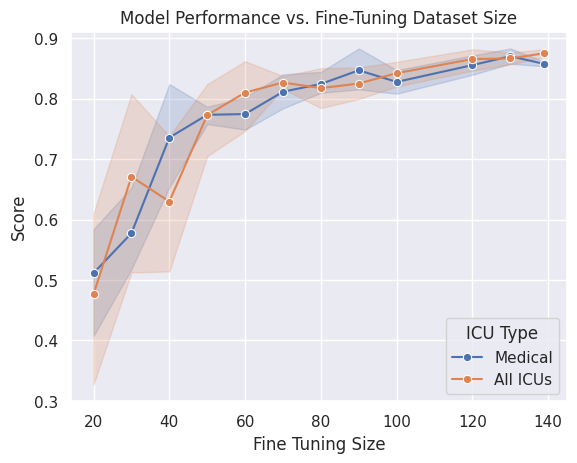

In [15]:
sns.set_theme()

sns.lineplot(
    data=pvft, 
    x="Fine Tuning Size", 
    y="Score", 
    hue="ICU Type", 
    marker='o',
).set(title='Model Performance vs. Fine-Tuning Dataset Size')

# Fixed (n = 1000) vs. Maximum Pretraining Size

In [16]:
fvmp = results_raw[results_raw['Fine Tuning Size'] == ecmo_size].drop(columns=['Fine Tuning Size'])
fixed_pretraining = fvmp[fvmp['Pretraining Size'] == 1000]
max_pretraining = fvmp[fvmp['Pretraining Size'] == 0]

/tmp/ipykernel_2155146/2098602826.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


[Text(0.5, 1.0, 'Model Performance by Pretraining Dataset')]

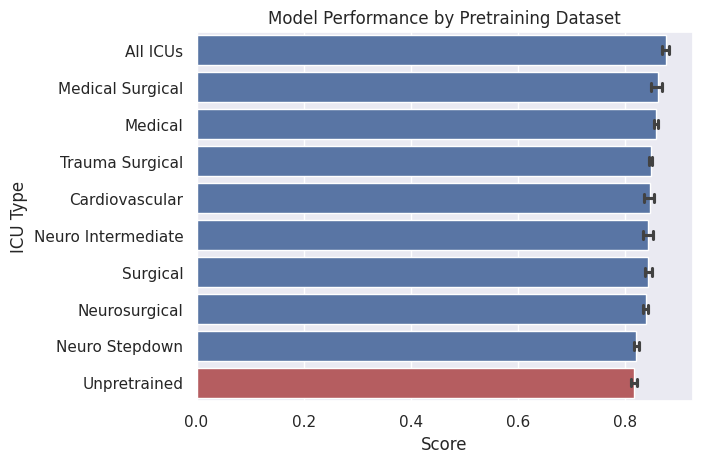

In [17]:
plot_order = max_pretraining.groupby('ICU Type')['Score'].mean().sort_values(ascending=False).index.values
clrs = ['r' if (x == 'Unpretrained') else 'b' for x in plot_order ]

sns.barplot(
    data=max_pretraining, 
    x="Score", 
    y="ICU Type", 
    capsize=0.2,
    order=plot_order,
    orient='h',
    palette=clrs
).set(title='Model Performance by Pretraining Dataset')

/tmp/ipykernel_2155146/1089638351.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


[Text(0.5, 1.0, 'Model Performance by Pretraining Dataset\nfixed pretraining dataset size (n=1000)')]

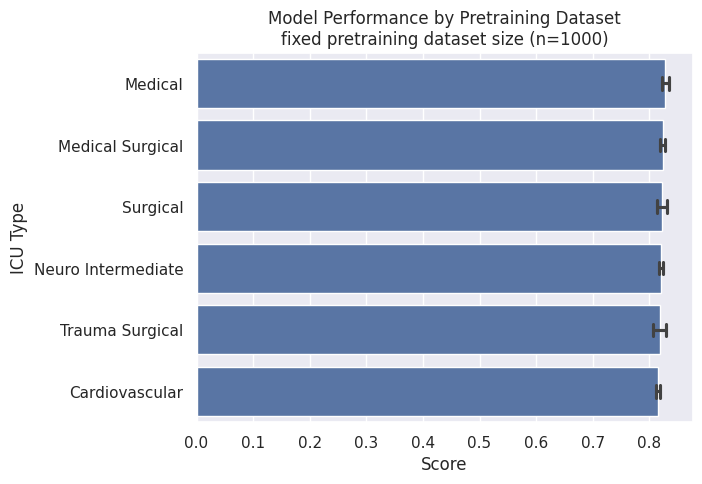

In [18]:
plot_order = fixed_pretraining.groupby('ICU Type')['Score'].mean().sort_values(ascending=False).index.values
clrs = ['r' if (x == 'Unpretrained') else 'b' for x in plot_order ]

sns.barplot(
    data=fixed_pretraining, 
    x="Score", 
    y="ICU Type", 
    capsize=0.2,
    order=plot_order,
    orient='h',
    palette=clrs
).set(title="Model Performance by Pretraining Dataset\nfixed pretraining dataset size (n=1000)")

# Performance by Pretraining Dataset Size

In [25]:
pvpt = results_raw[(results_raw['Pretraining Size'] != 0) & (results_raw['Pretraining Size'] != 1000)]
pvpt

,ICU Type,Pretraining Size,Fine Tuning Size,Score,Seed,Timestamp
0,All ICUs,8,139,0.827708,42,2025-05-13 18:52:53.687448
1,All ICUs,8192,139,0.879792,42,2025-05-13 18:52:53.687448
29,All ICUs,32,139,0.829792,42,2025-05-13 18:52:53.687448
30,All ICUs,64,139,0.822917,42,2025-05-13 18:52:53.687448
31,All ICUs,128,139,0.823750,42,2025-05-13 18:52:53.687448
32,All ICUs,256,139,0.816250,42,2025-05-13 18:52:53.687448
33,All ICUs,512,139,0.816667,42,2025-05-13 18:52:53.687448
34,All ICUs,2048,139,0.828333,42,2025-05-13 18:52:53.687448
35,All ICUs,4096,139,0.837083,42,2025-05-13 18:52:53.687448
38,All ICUs,1024,139,0.835417,42,2025-05-13 18:52:53.687448


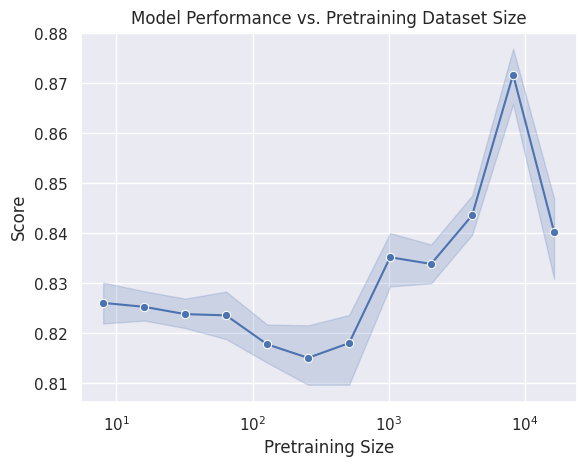

In [20]:
sns.set_theme()

sns.lineplot(
    data=pvpt, 
    x="Pretraining Size", 
    y="Score",
    marker='o',
).set(title='Model Performance vs. Pretraining Dataset Size')
plt.xscale('log')

# Attributions

In [21]:
from tabecmo.dataProcessing import features, feat_category_map

attribs_raw = torch.load('cache/attribs.pt')
attribs_raw = torch.abs(attribs_raw)
attribs_raw = torch.sum(attribs_raw, axis=0)

attribs_df = pd.DataFrame(data={'Feature': features, 'Attribution': attribs_raw})

attribs_df.to_csv("results/attributions.csv", index=False)
attribs_df['Category'] = attribs_df['Feature'].apply(lambda x: feat_category_map[x])

attribs_df

,Feature,Attribution,Category
0,basophils_abs,1.115038,cbc
1,eosinophils_abs,1.783032,cbc
2,lymphocytes_abs,1.946394,cbc
3,monocytes_abs,1.197141,cbc
4,neutrophils_abs,2.019917,cbc
...,...,...,...
74,total_protein,4.409298,LFTs
75,totalco2,3.823868,Blood Gases
76,ventilation,32.281143,Procedures
77,age,24.681093,Age


/tmp/ipykernel_2155146/2336011811.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2155146/2336011811.py:1: UserWarning: The palette list has more values (79) than needed (20), which may not be intended.
  sns.barplot(


[Text(0.5, 1.0, 'Summed Absolute Attributions')]

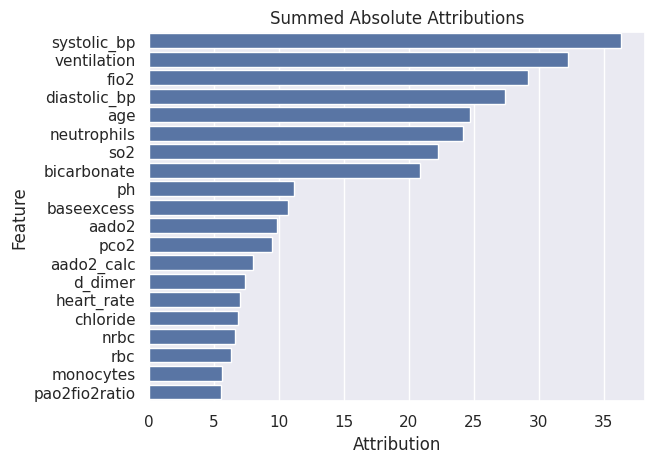

In [22]:

sns.barplot(
    data=attribs_df.nlargest(20, columns=['Attribution']),
    x="Attribution", 
    y="Feature", 
    orient='h',
    palette=['b'] * len(features)
).set(title='Summed Absolute Attributions')

In [23]:
# Unpretrained attribs

In [26]:

experiment_groups = results_raw[results_raw['Fine Tuning Size'] == 139].groupby(['ICU Type', 'Pretraining Size'])

aggregated_statistics = experiment_groups['Score'].agg(['mean', 'median', 'std', 'sem', 'count'])
aggregated_statistics.to_csv("results/aggregated_stats.csv")
aggregated_statistics

mean    median       std       sem  \
ICU Type           Pretraining Size                                           
All ICUs           0                 0.875375  0.875208  0.008607  0.003849   
                   8                 0.826083  0.826458  0.005405  0.002417   
                   16                0.825292  0.824375  0.003798  0.001698   
                   32                0.823833  0.824167  0.003815  0.001706   
                   64                0.823583  0.822917  0.006091  0.002724   
                   128               0.817792  0.815208  0.004900  0.002192   
                   256               0.815083  0.813958  0.007926  0.003544   
                   512               0.818042  0.821875  0.008986  0.004019   
                   1024              0.835208  0.836042  0.006500  0.002907   
                   2048              0.833875  0.832083  0.005014  0.002242   
                   4096              0.843583  0.842292  0.004994  0.002234   
                   8192              0.871750  0.873542  0.007282  0.003257   
                   16384             0.840292  0.842500  0.011000  0.004919   
Cardiovascular     0                 0.845583  0.851250  0.012279  0.005491   
                   1000              0.814958  0.815000  0.004258  0.001904   
Medical            0                 0.857500  0.855625  0.005071  0.002268   
                   1000              0.828375  0.824375  0.007042  0.003149   
Medical Surgical   0                 0.861125  0.867083  0.014093  0.006303   
                   1000              0.824042  0.826458  0.005476  0.002449   
Neuro Intermediate 0                 0.843417  0.845208  0.012292  0.005497   
                   1000              0.820667  0.821250  0.004491  0.002008   
Neuro Stepdown     0                 0.821083  0.818542  0.005912  0.002644   
Neurosurgical      0                 0.838167  0.839583  0.005890  0.002634   
Surgical           0                 0.843042  0.840625  0.008342  0.003731   
                   1000              0.822167  0.827708  0.011889  0.005317   
Trauma Surgical    0                 0.847708  0.848333  0.004335  0.001939   
                   1000              0.818625  0.820417  0.014326  0.006407   
Unpretrained       0                 0.815833  0.814375  0.006334  0.002833   

                                     count  
ICU Type           Pretraining Size         
All ICUs           0                     5  
                   8                     5  
                   16                    5  
                   32                    5  
                   64                    5  
                   128                   5  
                   256                   5  
                   512                   5  
                   1024                  5  
                   2048                  5  
                   4096                  5  
                   8192                  5  
                   16384                 5  
Cardiovascular     0                     5  
                   1000                  5  
Medical            0                     5  
                   1000                  5  
Medical Surgical   0                     5  
                   1000                  5  
Neuro Intermediate 0                     5  
                   1000                  5  
Neuro Stepdown     0                     5  
Neurosurgical      0                     5  
Surgical           0                     5  
                   1000                  5  
Trauma Surgical    0                     5  
                   1000                  5  
Unpretrained       0                     5